<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# import rosbag
import numpy as np 
import matplotlib.pyplot as plt
# from cv_bridge import CvBridge, CvBridgeError
# import sensor_msgs.point_cloud2 as pc2

import cv2

In [2]:
# bag = rosbag.Bag("/mnt/Garage/Data/2020-02-26-15-27-06_0.bag")

In [3]:
# depth_img_msgs = np.array([msg for topic, msg, t in bag.read_messages(topics=['/vision/zed/front/depth/image/compressedDepth'])])
# depth_cam_info_msgs = [msg for topic, msg, t in bag.read_messages(topics=['/vision/zed/front/depth/camera_info'])][0]

# rgb_img_msgs = np.array([msg for topic, msg, t in bag.read_messages(topics=['/vision/zed/front/rgb/image/compressed'])])
# rgb_cam_info_msgs = [msg for topic, msg, t in bag.read_messages(topics=['/vision/zed/front/rgb/camera_info'])][0]

# #one rgb image has no depth match
# rgb_img_msgs = rgb_img_msgs[:-1]

In [4]:
# def depth_by_id(img_id):
#     bridge = CvBridge()
#     return bridge.imgmsg_to_cv2(depth_img_msgs[img_id], "mono16")

# def rgb_by_id(img_id):
#     bridge = CvBridge()
#     return bridge.compressed_imgmsg_to_cv2(rgb_img_msgs[img_id], "bgr8")[:,:,::-1]

In [5]:
def load_depth_sample():
    return cv2.imread("../Data/depth_sample.png", cv2.IMREAD_ANYDEPTH)

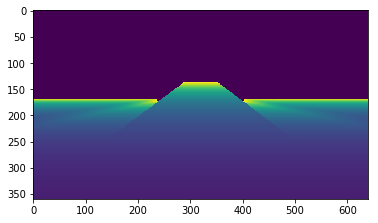

In [6]:
img = load_depth_sample()
plt.imshow(img)
assert(np.max(img) > 255)

In [7]:
# raw_data = depth_img_msgs[20].data[12:]
# img = cv2.imdecode(np.fromstring(raw_data, np.uint8), cv2.IMREAD_UNCHANGED)
# plt.imshow(img)

In [8]:
# plt.imshow(depth_by_id(0))

In [9]:
# plt.imshow(rgb_by_id(0))

In [10]:
depth_K = np.loadtxt("../Data/K")
depth_K_inv = np.linalg.inv(depth_K)
# rgb_K = np.array(rgb_cam_info_msgs.K).reshape((3, 3))
# depth2bgr_scale  = rgb_K[0, 0] / depth_K[0, 0]
depth_K

array([[133.33333333,   0.        , 320.        ],
       [  0.        , 133.33333333, 180.        ],
       [  0.        ,   0.        ,   1.        ]])

# RANSAC implementation

In [11]:
class RANSAC_Params:
    target_good_estimation_prob = 0.999
    all_inliers_chosen_prob = 0.2
    good_point_threshold = 3e-3
        
class RANSAC_RoadExtractor:
    _params = RANSAC_Params
    _num_iters = 1
    
    def __init__(self, params):
        np.random.seed(21)
        self.set_params(params)
        
    def estimate_road_plane(self, point_img):
        points, indexes = self._prepare_points_list(point_img)
        hypotheses = self._prepare_hypoteses(points)
        best_hypothesis, best_inliers = self._choose_best_hypothesis(hypotheses, points)
        mask = self._prepare_mask(point_img.shape, indexes, best_inliers)
        return best_hypothesis, mask
        
    def set_params(self, params):
        self._params.target_good_estimation_prob = params.target_good_estimation_prob
        self._params.all_inliers_chosen_prob = params.all_inliers_chosen_prob
        self._params.good_point_threshold = params.good_point_threshold
        self._calc_num_iterations()
        
    def _calc_num_iterations(self):
        self._num_iters = int(np.ceil(np.log(1 - self._params.target_good_estimation_prob) / \
                                      np.log(1 - self._params.all_inliers_chosen_prob)))
        print ("Calculated num of iterations: " + str(self._num_iters))
        
    def _prepare_hypoteses(self, points):
        plane_coefs = []
        random_inds = np.random.choice(len(points), (self._num_iters, 3))
        for i in range(self._num_iters):
            i1, i2, i3 = random_inds[i]
            if (i1 == i2) or (i1 == i3) or (i2 == i3):
                continue
            p1 = points[i1]
            p2 = points[i2]
            p3 = points[i3]
            plane_coefs.append(self._calc_plane_coefs(p1, p2, p3))
        return plane_coefs
    
    def _calc_plane_coefs(self, p1, p2, p3):
        d1 = p3 - p1
        d2 = p2 - p1
        norm_vec = np.cross(d1, d2)
        norm_vec /= np.linalg.norm(norm_vec)
        shift = np.dot(norm_vec, p1)
        return (norm_vec[0], norm_vec[1], norm_vec[2], -shift)
    
    def _choose_best_hypothesis(self, hypotheses, points):
        prepared_points = np.hstack((points, np.ones((len(points), 1), dtype=np.float64)))
        errors = (np.array(hypotheses).dot(prepared_points.T))
        inliers = np.abs(errors) < self._params.good_point_threshold
        inlier_count = np.sum(inliers, axis=1)
        assert(len(inlier_count) == len(hypotheses))
        best_ind = np.argmax(inlier_count)
        best_hypothesis = hypotheses[best_ind]
        best_inliers = inliers[best_ind]
        return best_hypothesis, best_inliers 
    
    def _prepare_points_list(self, point_img):
        points_list = np.array(point_img).reshape(-1, 3)
        indexes = np.arange(len(points_list)).reshape(-1, 1)
        indexes = np.hstack((indexes // point_img.shape[1], indexes % point_img.shape[1]))
        non_zero_points = np.sum(points_list**2, axis=1) > 1e-7
        points_list = points_list[non_zero_points]
        indexes = indexes[non_zero_points]
        return points_list, indexes
    
    def _prepare_mask(self, img_size, indexes, inliers):
        mask = np.zeros(img_size[:2])
        indexes = indexes[inliers]
        for index in indexes:
            mask[index[0], index[1]] = 1
        return mask
        
def depth2xyz_img(depth_img):
    coords = np.zeros((depth_img.shape[0], depth_img.shape[1], 3))
    for i in range(coords.shape[0]):
        for j in range(coords.shape[1]):
            coords[i, j] = depth_K_inv.dot([j, i , 1]) * depth_img[i, j] / 1000.
    return coords

In [12]:
sample_ind = 0
# rgb_sample = rgb_by_id(sample_ind)
# xyz_sample = depth2xyz_img(depth_by_id(sample_ind))
xyz_sample = depth2xyz_img(load_depth_sample())
xyz_sample /= np.max(xyz_sample)
cv2.imshow("sample", xyz_sample)
cv2.waitKey(50)

255

Calculated num of iterations: 31


True

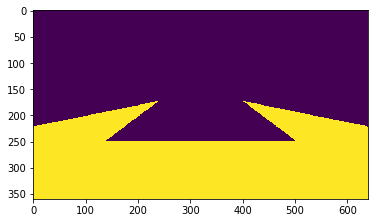

In [13]:
params = RANSAC_Params
params.good_point_threshold = 6e-5
extractor = RANSAC_RoadExtractor(params)
sample_coefs, sample_mask = extractor.estimate_road_plane(xyz_sample)
plt.imshow(sample_mask)
cv2.imwrite("../Data/RANSAC_mask.png", sample_mask * 255)

In [14]:
# def merge_rgb_n_mask(rgb_img, mask):
#     convex_sum_coef = 0.4
#     merge_mask = cv2.resize(mask, (rgb_img.shape[1], rgb_img.shape[0])) * convex_sum_coef
#     merged = rgb_img / 255. *  (1 - convex_sum_coef)
#     merged[:,:,1] += merge_mask
#     return merged

In [15]:
# plt.imshow(merge_rgb_n_mask(rgb_sample, sample_mask))